In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
import torchvision
from PIL import Image
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os
import time



train_data_path = "drive/My Drive/University/master project/dataset/ALL IDB splitted/train"
test_data_path = "drive/My Drive/University/master project/dataset/ALL IDB splitted/test"
normal_centroids_path = "drive/My Drive/University/master project/faster RCNN/normal cell centroids"
blast_centroids_path = "drive/My Drive/University/master project/dataset/ALL IDB/ALL_IDB1/xyc"
box_width = 200

In [ ]:
image_names = os.listdir(train_data_path)
print(image_names)
print(len(image_names))

['Im034_0.jpg', 'Im063_1.jpg', 'Im044_0.jpg', 'Im036_0.jpg', 'Im083_0.jpg', 'Im023_1.jpg', 'Im037_0.jpg', 'Im097_0.jpg', 'Im002_1.jpg', 'Im020_1.jpg', 'Im010_1.jpg', 'Im032_1.jpg', 'Im053_1.jpg', 'Im004_1.jpg', 'Im041_0.jpg', 'Im052_1.jpg', 'Im085_0.jpg', 'Im107_0.jpg', 'Im070_0.jpg', 'Im075_0.jpg', 'Im108_0.jpg', 'Im027_1.jpg', 'Im028_1.jpg', 'Im102_0.jpg', 'Im031_1.jpg', 'Im077_0.jpg', 'Im045_0.jpg', 'Im106_0.jpg', 'Im067_0.jpg', 'Im006_1.jpg', 'Im022_1.jpg', 'Im073_0.jpg', 'Im089_0.jpg', 'Im026_1.jpg', 'Im104_0.jpg', 'Im105_0.jpg', 'Im101_0.jpg', 'Im016_1.jpg', 'Im091_0.jpg', 'Im060_1.jpg', 'Im086_0.jpg', 'Im003_1.jpg', 'Im056_1.jpg', 'Im024_1.jpg', 'Im084_0.jpg', 'Im059_1.jpg', 'Im065_0.jpg', 'Im011_1.jpg', 'Im088_0.jpg', 'Im049_1.jpg', 'Im054_1.jpg', 'Im043_0.jpg', 'Im096_0.jpg', 'Im007_1.jpg', 'Im017_1.jpg', 'Im103_0.jpg', 'Im005_1.jpg', 'Im040_0.jpg', 'Im062_1.jpg', 'Im013_1.jpg', 'Im066_0.jpg', 'Im009_1.jpg', 'Im080_0.jpg', 'Im042_0.jpg', 'Im064_0.jpg', 'Im019_1.jpg', 'Im090_0.

# Data

In [ ]:
def read_annotations(annotation_path):
    with open(annotation_path) as f:
        annotation = f.read()
    raw_data = annotation.split("\n")[:-1]
    xys = []
    for string in raw_data:
        if len(string) > 0:
            s = string.split("\t")
            x = int(s[0])
            y = int(s[1])
            xys.append((x, y))
    
    return xys

In [ ]:
class CellDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, blast_centroids_path, normal_centroids_path, box_width):
        self.data_path = data_path
        self.normal_centroids_path = normal_centroids_path
        self.blast_centroids_path = blast_centroids_path
        self.box_width = box_width
        self.image_names = []
        self.image_names = os.listdir(self.data_path)
        

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.data_path, image_name)
        annotation_path = os.path.join(self.blast_centroids_path, image_name[:-3] + 'xyc')

        xys_blast = read_annotations(annotation_path)
        xys_normal = self.read_normal_annotations(image_name)


        img = Image.open(img_path).convert("RGB")
        img = F.to_tensor(img)

        box_list = []
        for x, y in xys_blast:
            x_min = max(x - self.box_width / 2, 0)
            x_max = min(x + self.box_width / 2, img.shape[2])
            y_min = max(y - self.box_width / 2, 0)
            y_max = min(y + self.box_width / 2, img.shape[1])
            box_list.append((x_min, y_min, x_max, y_max))
        
        for x, y in xys_normal:
            x_min = max(x - self.box_width / 2, 0)
            x_max = min(x + self.box_width / 2, img.shape[2])
            y_min = max(y - self.box_width / 2, 0)
            y_max = min(y + self.box_width / 2, img.shape[1])
            box_list.append((x_min, y_min, x_max, y_max))
        
        boxes = torch.tensor(box_list, dtype = torch.float32)

        labels_blast = torch.ones((len(xys_blast), ), dtype = torch.int64)
        labels_normal = torch.ones((len(xys_normal), ), dtype = torch.int64) * 2
        labels = torch.cat((labels_blast, labels_normal), dim = 0)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return img, target

    def read_normal_annotations(self, image_name):
        xys_normal_numpy = np.load(os.path.join(self.normal_centroids_path, image_name[:-4] + ".npy"))
        xys_normal = []
        for k in range(xys_normal_numpy.shape[0]):
            y = int(xys_normal_numpy[k, 0])
            x = int(xys_normal_numpy[k, 1])
            xys_normal.append((x, y))
        
        return xys_normal

    def __len__(self):
        return len(self.image_names)
  

test dataset

dataset length : 75
torch.float32
torch.Size([2, 4])
torch.int64
torch.Size([2])


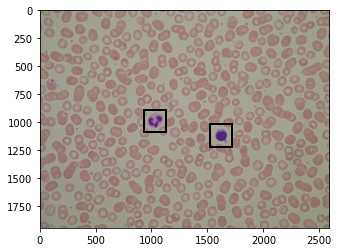

In [ ]:
idx = 3

cell_dataset = CellDataset(train_data_path, blast_centroids_path, normal_centroids_path, box_width)
print("dataset length : {}".format(cell_dataset.__len__()))


img, target = cell_dataset.__getitem__(idx)



print(target['boxes'].dtype)
print(target['boxes'].shape)
print(target['labels'].dtype)
print(target['labels'].shape)



np_img = img.permute(1, 2, 0).numpy()
boxes = target['boxes']
labels = target['labels']

plt.imshow(np_img)
ax = plt.gca()
for box, label in zip(boxes, labels):
    rect = Rectangle((box[0], box[1]),
                      box[2] - box[0],
                      box[3] - box[1],
                      fill = False,
                      linewidth = 2)
    ax.add_patch(rect)

plt.show()

data loder

In [ ]:
cell_dataset_train = CellDataset(train_data_path, blast_centroids_path, normal_centroids_path, box_width)
cell_dataset_test = CellDataset(test_data_path, blast_centroids_path, normal_centroids_path, box_width)

In [ ]:
def new_concat(batch):
  return tuple(zip(*batch))

In [ ]:
train_loader = torch.utils.data.DataLoader(cell_dataset,
                                           batch_size = 4,
                                           collate_fn = new_concat)
val_loader = torch.utils.data.DataLoader(cell_dataset,
                                         batch_size = 2,
                                         collate_fn = new_concat)

test dataloder

In [ ]:
print(next(iter(train_loader)))

((tensor([[[0.6196, 0.6078, 0.6118,  ..., 0.6275, 0.6314, 0.6314],
         [0.6314, 0.6039, 0.6235,  ..., 0.6235, 0.6275, 0.6353],
         [0.6431, 0.6157, 0.6196,  ..., 0.6314, 0.6353, 0.6314],
         ...,
         [0.5765, 0.5843, 0.5882,  ..., 0.6118, 0.6196, 0.6078],
         [0.5765, 0.5882, 0.5922,  ..., 0.6118, 0.6039, 0.5922],
         [0.5843, 0.5882, 0.5922,  ..., 0.6118, 0.6000, 0.6000]],

        [[0.6039, 0.5804, 0.5686,  ..., 0.5882, 0.5922, 0.5922],
         [0.6039, 0.5686, 0.5686,  ..., 0.5843, 0.5882, 0.5961],
         [0.6039, 0.5725, 0.5647,  ..., 0.5922, 0.5961, 0.5922],
         ...,
         [0.5255, 0.5333, 0.5373,  ..., 0.6314, 0.6392, 0.6275],
         [0.5255, 0.5373, 0.5412,  ..., 0.6235, 0.6157, 0.6039],
         [0.5333, 0.5373, 0.5412,  ..., 0.6235, 0.6157, 0.6157]],

        [[0.5608, 0.5412, 0.5451,  ..., 0.5490, 0.5529, 0.5529],
         [0.5804, 0.5490, 0.5569,  ..., 0.5451, 0.5490, 0.5569],
         [0.5961, 0.5647, 0.5608,  ..., 0.5451, 0.5490, 

# Model

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024, 3)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Optimizer

In [ ]:
optimizer = torch.optim.SGD(model.parameters(),
                            lr = 0.005,
                            momentum = 0.9)

# Train

In [ ]:
def train_one_epoch(model, optimizer, device, train_dataloader):
    model.train()
    total_loss = 0
    for images, targets in train_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    return total_loss / len(train_dataloader)

In [ ]:
num_epochs = 100

start_time = time.time()

for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, device, train_loader)
    duration = time.time() - start_time
    print("epoch[{}]: \t Loss : {}\t Duration : {}".format(epoch + 1, loss, duration))
    start_time = time.time()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch[1]: 	 Loss : 0.9220371246337891	 Duration : 74.91889333724976
epoch[2]: 	 Loss : 0.5849307179450989	 Duration : 19.150806188583374
epoch[3]: 	 Loss : 0.45330801606178284	 Duration : 19.14851951599121
epoch[4]: 	 Loss : 0.37774568796157837	 Duration : 19.316600561141968
epoch[5]: 	 Loss : 0.3225193917751312	 Duration : 19.520575046539307
epoch[6]: 	 Loss : 0.2826797366142273	 Duration : 19.61000919342041
epoch[7]: 	 Loss : 0.2758543789386749	 Duration : 19.726804733276367
epoch[8]: 	 Loss : 0.2455742210149765	 Duration : 19.865931272506714
epoch[9]: 	 Loss : 0.20788118243217468	 Duration : 20.116647005081177
epoch[10]: 	 Loss : 0.1964988261461258	 Duration : 20.629789352416992
epoch[11]: 	 Loss : 0.22755131125450134	 Duration : 21.05274772644043
epoch[12]: 	 Loss : 0.20118224620819092	 Duration : 20.80637001991272
epoch[13]: 	 Loss : 0.17600996792316437	 Duration : 20.384031295776367
epoch[14]: 	 Loss : 0.1559014469385147	 Duration : 20.455222845077515
epoch[15]: 	 Loss : 0.172348

In [ ]:
torch.save(model.state_dict(), "drive/My Drive/University/master project/faster RCNN/trained networks/res_net_50_backbone_blast_normal_on_train_folder.pt")

# Evaluate

In [ ]:
def evaluate(model, device, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images, targets in test_dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.7
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            img = images[0].permute(1, 2, 0).cpu().numpy()
            
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.imshow(img)
            for j in range(len(gt)):
                rect_1 = Rectangle((int(gt[j][0]), int(gt[j][1])),
                                   abs(gt[j][0] - gt[j][2]),
                                   abs(gt[j][1] - gt[j][3]),
                                   linewidth = 3,
                                   edgecolor = 'g',
                                   facecolor = 'none')
                ax.add_patch(rect_1)
            for i in range(len(bxs)):
                rect = Rectangle((int(bxs[i][0]), int(bxs[i][1])),
                                 abs(bxs[i][0] - bxs[i][2]),
                                 abs(bxs[i][1] - bxs[i][3]),
                                 linewidth = 3,
                                 edgecolor = 'r',
                                 facecolor = 'none')
                ax.add_patch(rect)
            
            fig.savefig("drive/My Drive/University/master project/faster RCNN/ResNet 50 backbone results/{}.png".format(cnt), dpi = 90, bbox_inches = 'tight')
            cnt += 1

In [ ]:
evaluate(model, device, val_loader)